In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [458]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from copy import deepcopy

In [533]:
def one_hots(zeros, ix):
    for i in range(zeros.size()[0]):
        zeros[i, ix[i]] = 1
    return zeros

def bleu2(t, r, f, temp):
    t_soft = f(t)
    t_soft = f(t_soft/temp)
    length = t.size()[0]
    tt_1 = torch.matmul(t_soft, t_soft.t())
    tt_1 = tt_1 * Variable(1 - torch.eye(length)) + Variable(torch.eye(length))
#     for i in range(t.size()[0]):
#         tt_1.data[i, i] = 1
    tr_1 = torch.matmul(t_soft, r.t())
#     tt_2 = torch.matmul(t_temp[:-1, :], t_temp[:-1, :].t()) * torch.matmul(t_temp[1:, :], t_temp[1:, :].t())
#     tr_2 = torch.matmul(t_temp[:-1, :], r[:-1, :].t()) * torch.matmul(t_temp[1:, :], r[1:, :].t())
    t_vec_1 = tt_1.sum(0)
    c_vec_1 = tr_1.sum(1)
#     t_vec_2 = tt_2.sum(0)
#     c_vec_2 = tr_2.sum(1)
    overlap_1 = torch.min(t_vec_1, c_vec_1) / t_vec_1 / length
#     overlap_2 = torch.min(t_vec_2, c_vec_2) / t_vec_2 / length
#     overlap = overlap_2.sum() * overlap_1.sum()
#     overlap = (c_vec_1 / length).sum()
    return overlap_1.sum()

In [576]:
def bleu_lb1(t, r, f, temp):
    length = t.size()[0]
    vocab_size = t.size()[1]
    t_soft = f(t)
    r_n = r.sum(0)  # word counter in reference
    im = torch.eye(vocab_size)
    O = {}
    for i in range(length):
        aye = Variable(torch.ones((vocab_size, vocab_size)) - torch.eye(vocab_size))
        aye = torch.matmul(t, aye)
        aye[i, :] = 1
        aye = torch.prod(aye, 0)
        O[i] = (t[i, :] * r_n * aye).sum()   # replace with HS function
    return sum(list(O.values()))

In [577]:
def bleu_lbj(t, r, f, temp):
    length = t.size()[0]
    vocab_size = t.size()[1]
    t_soft = f(t)
    r_n = r.sum(0)  # word counter in reference
    im = torch.eye(vocab_size)
    O = {}
    for i in range(length):
        aye = Variable(torch.ones((vocab_size, vocab_size)) - torch.eye(vocab_size))
        aye = torch.matmul(t, aye)
        aye[i, :] = 1
        aye = torch.prod(aye, 0)
        O[i] = (t[i, :] * r_n * aye).sum()   # replace with HS function
    return sum(list(O.values()))

In [567]:
vocab_size = 100
length = 5
words = np.random.choice(vocab_size, size=length, replace=True)
t = Variable(torch.randn((length, vocab_size)), requires_grad=True)
r = one_hots(torch.zeros((length, vocab_size)), words)
r = Variable(r, requires_grad=True)
f = nn.Softmax()

In [568]:
res = []
bleus = []
norms = []                                                                                                                            
lr = 0.001
#optimizer = optim.SGD([t], lr=lr, momentum=0.)
optimizer = optim.Adam([t], lr=lr)
for i in range(10):
    optimizer.zero_grad()
    temp = 1.
    b2 = -bleu(t, r, f, temp)  # minus for opt!!
    res.append(b2.data[0])
    b2.backward()
    #t.grad = t.grad * 10e20
    #norm = nn.utils.clip_grad_norm([t], 1)
    #t.data.add_(lr * t.grad.data)
    optimizer.step()
    norms.append(t.grad.data.norm())
    hard_t = one_hots(torch.zeros(list(t.size())), torch.max(t, dim=1)[1].data)
    #bleus.append(bleu(hard_t, r, f, temp).data[0])

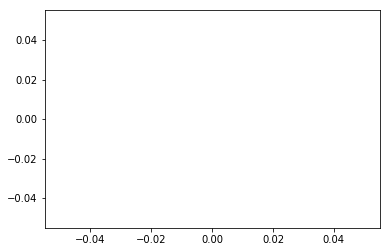

In [569]:
plt.plot(bleus)

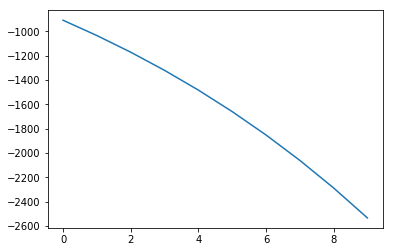

In [570]:
plt.plot(res)

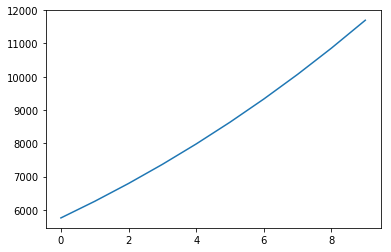

In [571]:
plt.plot(norms)

In [572]:
len(set(torch.max(r, dim=1)[1].data) & set(torch.max(t, dim=1)[1].data))

0

In [573]:
torch.max(r, dim=1)[1]

Variable containing:
 98
 30
  9
 91
 91
[torch.LongTensor of size 5]

In [574]:
torch.max(t, dim=1)[1]

Variable containing:
 86
 83
 73
 78
  8
[torch.LongTensor of size 5]

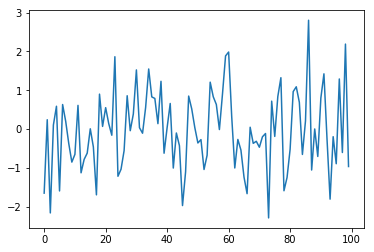

In [575]:
plt.plot(t.data[0].numpy())

In [502]:
temp = 1
bleu(t, r, f, temp).data[0]

0.011593794450163841

In [ ]:
vocab_size = 1000
length = 10
words = np.random.choice(vocab_size, size=length, replace=True)
t = Variable(torch.randn((length, vocab_size)), requires_grad=True)
r = one_hots(torch.zeros((length, vocab_size)), words)
r = Variable(r, requires_grad=True)
f = nn.Softmax()

In [ ]:
t_temp = f(t/temp)
length = t.size()[0]
tt_1 = torch.matmul(t_temp, t_temp.t())
tr_1 = torch.matmul(t_temp, r.t())
tt_2 = torch.matmul(t_temp[:-1, :], t_temp[:-1, :].t()) * torch.matmul(t_temp[1:, :], t_temp[1:, :].t())
tr_2 = torch.matmul(t_temp[:-1, :], r[:-1, :].t()) * torch.matmul(t_temp[1:, :], r[1:, :].t())
t_vec_1 = tt_1.sum(0)
c_vec_1 = tr_1.sum(1)
t_vec_2 = tt_2.sum(0)
c_vec_2 = tr_2.sum(1)
overlap_1 = torch.min(t_vec_1, c_vec_1) / t_vec_1 / length
overlap_2 = torch.min(t_vec_2, c_vec_2) / t_vec_2 / length
overlap = overlap_2.sum() * overlap_1.sum()
overlap = (c_vec_1 / length).sum()

In [ ]:
for i in range(10):
    tt_1[i, i] = 1

In [535]:
a = torch.randn((3, 5))

In [539]:
a[0:0]

ValueError: result of slicing is an empty tensor

In [ ]:
tt_1 = tt_1 * (1 - torch.eye(length)) + torch.eye(length)

In [ ]:
Variable(1- torch.eye(length)) * tt_1

In [ ]:
tt_1